In [2]:
# Extrapolate Macroeconomic Features Using Exponential Smoothing

import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load and prepare dataset
df = pd.read_csv("selected_features_83_w_rare_events.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values("date")

In [4]:
# Identify macro features (excluding rare event flags)
flag_cols = [col for col in df.columns if 'flag' in col.lower()]
macro_features = df.drop(columns=["date"] + flag_cols).select_dtypes(include=[float, int]).columns.tolist()

In [18]:
# Forecast horizon: 120 months (10 years)
forecast_months = 120
future_dates = pd.date_range(start=df['date'].max() + pd.DateOffset(months=1), periods=forecast_months, freq="MS")

In [20]:
# Forecast each macro feature using Exponential Smoothing (with ARIMA as a fallback where the optimzer can't converge)
forecasted_data = {}
for feature in macro_features:
    try:
        model = ExponentialSmoothing(df[feature], trend='add', seasonal=None)
        results = model.fit(optimized=True)
        forecast = results.forecast(forecast_months)
        forecasted_data[feature] = forecast.values
    except:
        # Try ARIMA fallback
        try:
            arima_model = SARIMAX(df[feature], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False, enforce_invertibility=False)
            arima_results = arima_model.fit(disp=False)
            arima_forecast = arima_results.forecast(steps=forecast_months)
            forecasted_data[feature] = arima_forecast.values
        except:
            # Fallback to last known value
            forecasted_data[feature] = np.full(forecast_months, df[feature].iloc[-1])

/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sophiaboettcher/anaconda3/li

In [22]:
# Build future DataFrame
df_future = pd.DataFrame(forecasted_data)
df_future['date'] = future_dates

# Add NaN placeholders for rare event flags (since we can't know the future labels)
for col in flag_cols:
    df_future[col] = np.nan

In [28]:
# Combine historical and forecasted data
df_combined = pd.concat([df, df_future], ignore_index=True)

# Save or preview
df_combined.to_csv("extrapolated_macro_features.csv", index=False)
# display(df_combined.tail())

In [26]:
df_combined.tail()

,date,Volume_AAPL,Volume_AMZN,Volume_AMD,Volume_CSCO,Volume_ERIC,Volume_ADBE,Volume_FCEL,Volume_FORD,Rolling_Std_30d,...,Interest Rate_lag30_lag180,Interest Rate_lag30_lag90_lag180,layman__rental_vacancy_rate,layman__auto_loan_rate,Interest Rate_lag30_lag90_lag180_rolling180,liquidity_crunch_index,layman__mortgage_rate,market_stress_flag,market_shock_flag,nber_recession_flag
8407,2035-01-01,1.181059e+08,8.738536e+07,7.035550e+07,3.785767e+07,3.951521e+07,6.611119e+06,679666.769763,80514.013619,74.589538,...,5.400505,5.520219,6.9,8.12,5.123400,1.110734,6.850002,NaN,NaN,NaN
8408,2035-02-01,1.180769e+08,8.737427e+07,7.035988e+07,3.785712e+07,3.951851e+07,6.611204e+06,679718.812243,80520.457397,74.589538,...,5.401113,5.521859,6.9,8.12,5.123425,1.110734,6.850002,NaN,NaN,NaN
8409,2035-03-01,1.180479e+08,8.736318e+07,7.036425e+07,3.785657e+07,3.952181e+07,6.611289e+06,679770.854722,80526.901174,74.589538,...,5.401720,5.523499,6.9,8.12,5.123450,1.110734,6.850002,NaN,NaN,NaN
8410,2035-04-01,1.180188e+08,8.735209e+07,7.036863e+07,3.785601e+07,3.952511e+07,6.611374e+06,679822.897202,80533.344952,74.589538,...,5.402328,5.525139,6.9,8.12,5.123475,1.110734,6.850002,NaN,NaN,NaN
8411,2035-05-01,1.179898e+08,8.734100e+07,7.037300e+07,3.785546e+07,3.952840e+07,6.611459e+06,679874.939681,80539.788730,74.589538,...,5.402936,5.526779,6.9,8.12,5.123500,1.110734,6.850002,NaN,NaN,NaN


In [30]:
# # In your local Jupyter environment:
# df = pd.read_csv("extrapolated_macro_features.csv")
# df_2025_2026 = df[(df['date'] >= '2025-01-01') & (df['date'] < '2027-01-01')]
# df_2025_2026.to_csv("extrapolated_2025_2026.csv", index=False)

📈 Top Moving Features in 2025–2026:
                                      feature   mean_change  percent_change  \
21                layman__cpi_event_admission  5.360983e-01    7.080084e-02   
14                                  High_FCEL -4.321943e+01   -4.274919e+02   
62                         federal_funds_rate  8.375522e-13    1.571393e-11   
78                layman__rental_vacancy_rate  1.348077e-11    1.953735e-10   
29                          layman__oil_price  4.789689e-08    6.611940e-08   
57                        linchpin__vix_index  1.369171e-06    7.891476e-06   
70  Unemployment_lag30_lag90_lag180_rolling90  7.980049e-08    2.131803e-06   
47                  Consumer Sentiment_lag180 -2.019063e-02   -2.615367e-02   
39                             interest rates  2.486525e-02    3.406198e-02   
61                         stock market crash -4.583007e-03   -9.166014e-02   

    z_score_spread  
21        4.065925  
14        4.008466  
62        3.941373  
78        

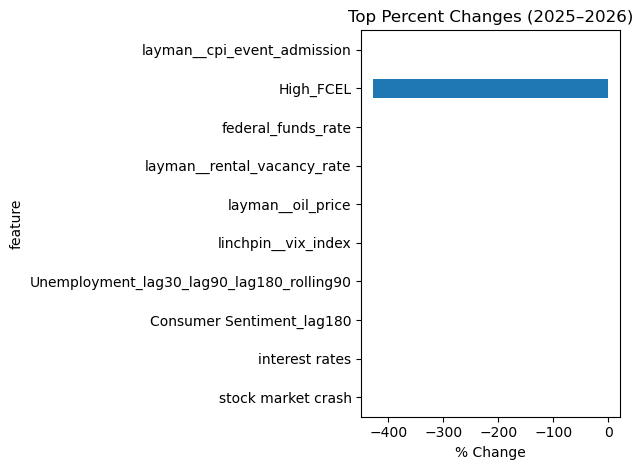

In [102]:
import pandas as pd
import numpy as np

# Load trimmed dataset
df = pd.read_csv("extrapolated_2025_2026.csv", parse_dates=["date"])

# Restrict to numeric features
# numeric_cols = df.select_dtypes(include=[float, int]).columns
# Redefine numeric columns cleanly
numeric_cols = [col for col in df.select_dtypes(include=[float, int]).columns if "flag" not in col.lower()]

# Compute trends for each feature
trends = []
for col in numeric_cols:
    first_val = df[col].iloc[0]
    last_val = df[col].iloc[-1]
    mean_change = last_val - first_val
    pct_change = ((last_val - first_val) / first_val) * 100 if first_val != 0 else np.nan
    std_dev = df[col].std()
    z_spread = abs(mean_change / std_dev) if std_dev != 0 else np.nan
    trends.append((col, mean_change, pct_change, z_spread))

# Create summary DataFrame
trend_df = pd.DataFrame(trends, columns=["feature", "mean_change", "percent_change", "z_score_spread"])
trend_df = trend_df.sort_values(by="z_score_spread", ascending=False)

# Show top movers
print("📈 Top Moving Features in 2025–2026:")
print(trend_df.head(10))

# Optional: plot top changes
import matplotlib.pyplot as plt
trend_df.head(10).set_index("feature")["percent_change"].plot(kind="barh", title="Top Percent Changes (2025–2026)")
plt.gca().invert_yaxis()
plt.xlabel("% Change")
plt.tight_layout()
plt.show()

In [104]:
monthly_volatility = df[numeric_cols].diff().std().sort_values(ascending=False)
print("🌪️ Most Volatile Features (MoM):")
print(monthly_volatility.head(10))

🌪️ Most Volatile Features (MoM):
Volume_AAPL                            1.778263e+07
Volume_AMD                             1.297944e+07
Volume_AMZN                            1.249827e+07
Volume_CSCO                            8.826851e+06
Volume_ERIC                            6.135550e+06
Volume_ADBE                            1.640619e+06
Volume_FCEL                            2.643251e+05
Volume_FORD                            5.818761e+04
layman__initial_unemployment_claims    2.549405e+02
layman__durable_goods_orders           5.630935e+01
dtype: float64


<Axes: title={'center': '🌡️ Macro Temperature Trends (Rolling Averages)'}, xlabel='date'>

/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  func(*args, **kwargs)
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


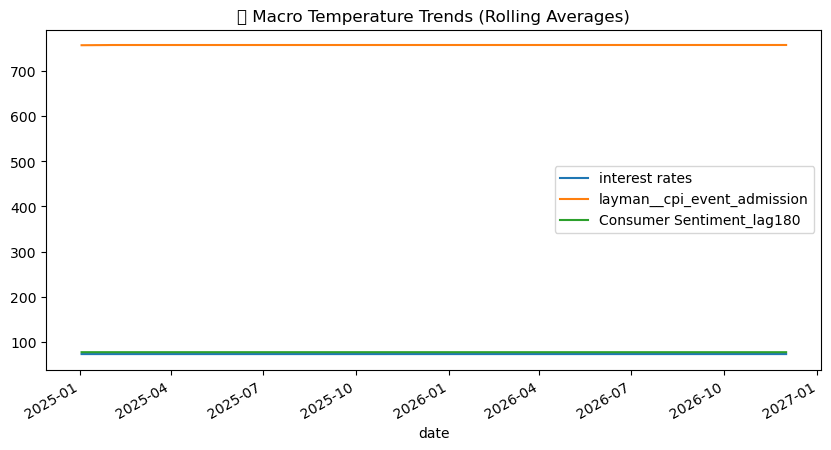

In [106]:
rolling = df[['date', 'interest rates', 'layman__cpi_event_admission', 'Consumer Sentiment_lag180']].copy()
rolling.set_index('date', inplace=True)
rolling = rolling.rolling(window=3).mean()  # 3-month smoothing

rolling.plot(title="🌡️ Macro Temperature Trends (Rolling Averages)", figsize=(10, 5))

/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


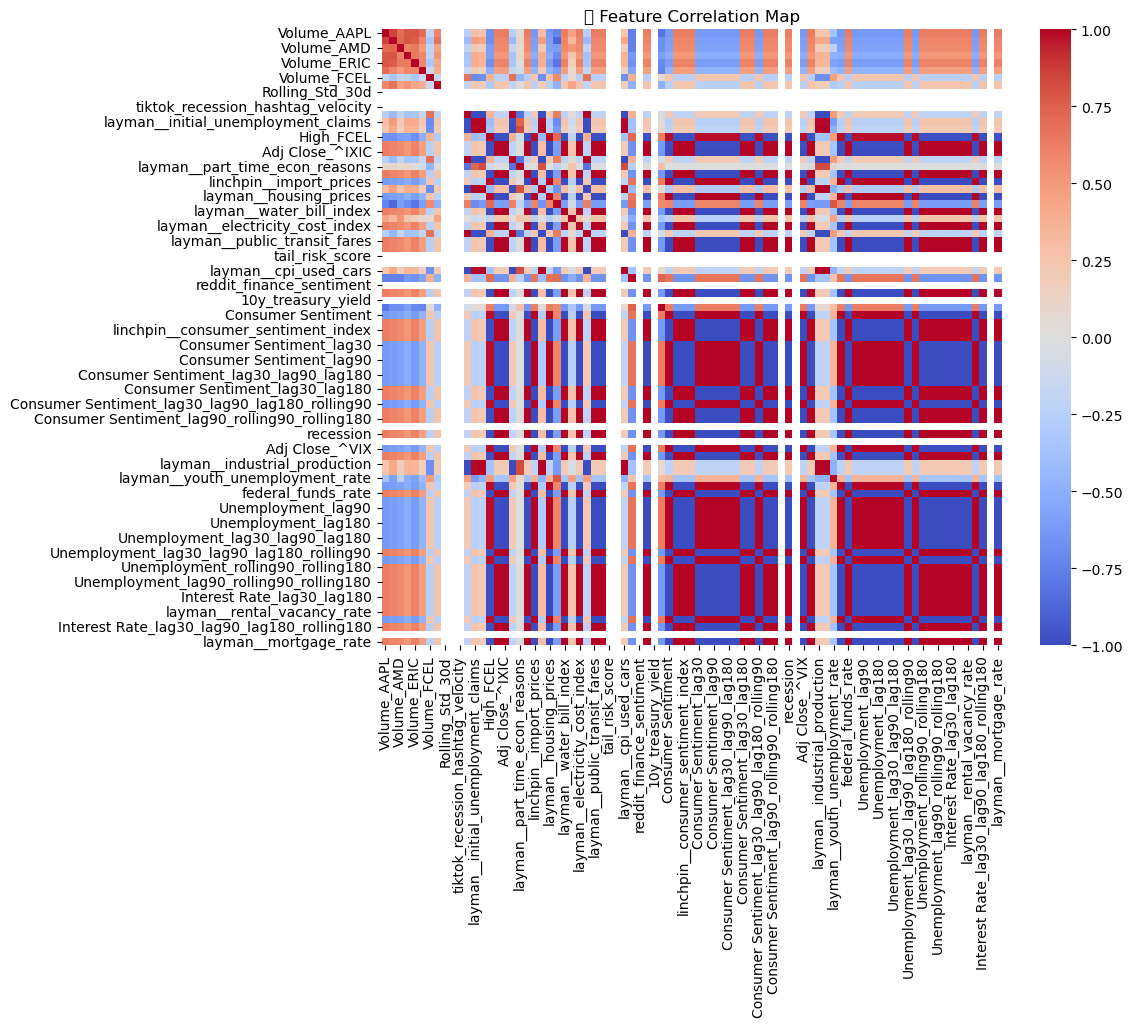

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("🔗 Feature Correlation Map")
plt.show()

/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_83878/1589848219.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_filled = X.fillna(method='ffill').fillna(method='bfill')
/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_83878/1589848219.py:48: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  plt.tight_layout()
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


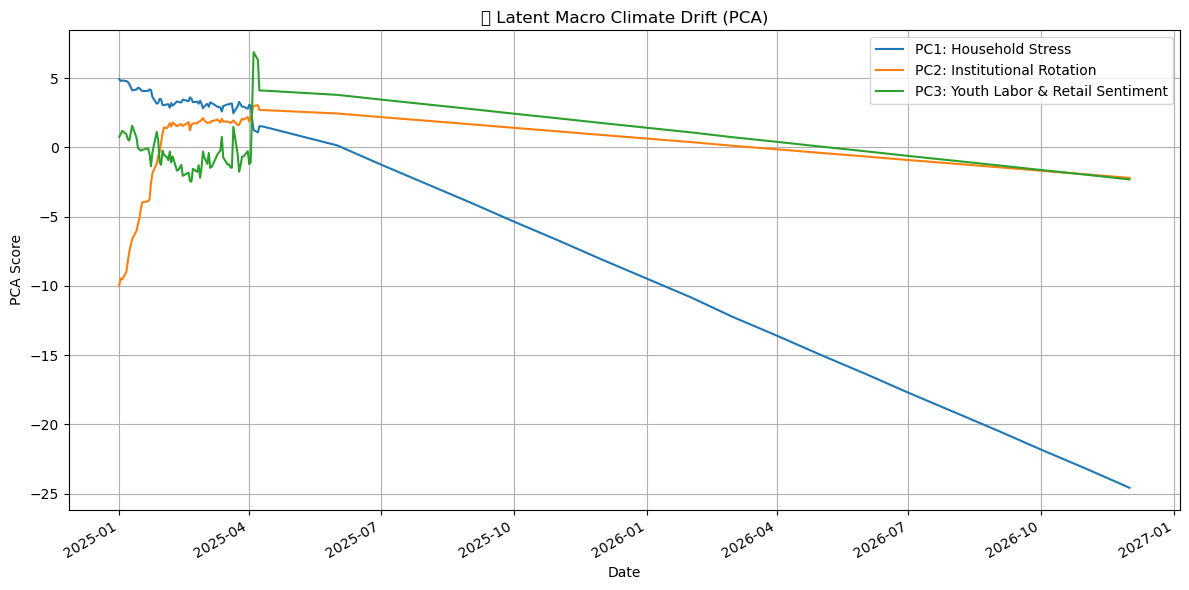

In [120]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Step 1: Filter clean numeric macro features (no flags)
numeric_cols = [col for col in df.select_dtypes(include=[float, int]).columns if 'flag' not in col.lower()]
X = df[numeric_cols]

# ✅ Step 2: Fill gaps forward and backward to preserve extrapolated months
X_filled = X.fillna(method='ffill').fillna(method='bfill')

# ✅ Step 3: Normalize
X_scaled = StandardScaler().fit_transform(X_filled)

# ✅ Step 4: Keep full date range
valid_dates = df["date"].values

# ✅ Step 5: Apply PCA
pca = PCA(n_components=3)
latent = pca.fit_transform(X_scaled)

# ✅ Step 6: Create labeled PCA DataFrame
latent_df = pd.DataFrame(
    latent,
    columns=[
        "PC1: Household Stress",
        "PC2: Institutional Rotation",
        "PC3: Youth Labor & Retail Sentiment"
    ]
)
latent_df["date"] = valid_dates

# ✅ 🔍 Optional: Spike detection on PC1 (or others)
latent_df["PC1_delta"] = latent_df["PC1: Household Stress"].diff()
latent_df["PC1_alert"] = (latent_df["PC1_delta"].abs() > 2 * latent_df["PC1_delta"].std())

# ✅ Step 7: Plot Latent Climate Drift
latent_df.set_index("date")[
    ["PC1: Household Stress", "PC2: Institutional Rotation", "PC3: Youth Labor & Retail Sentiment"]
].plot(
    title="🌀 Latent Macro Climate Drift (PCA)",
    figsize=(12, 6)
)
plt.ylabel("PCA Score")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

In [112]:
# Get PCA component loadings
loadings = pd.DataFrame(pca.components_.T, columns=["PC1", "PC2", "PC3"], index=numeric_cols)

In [100]:
for pc in ["PC1", "PC2", "PC3"]:
    print(f"\n🔍 Top contributors to {pc}:")
    print(loadings[pc].sort_values(key=abs, ascending=False).head(10))


🔍 Top contributors to PC1:
Adj Close_^VIX                                     0.137357
Adj Close_^IXIC                                   -0.137337
Interest Rate_lag30_lag180                        -0.137323
Interest Rate                                      0.137323
Interest Rate_lag30_lag90                         -0.137322
linchpin__housing_starts                          -0.137322
market crash                                      -0.137322
Consumer Sentiment_lag30_lag90_lag180_rolling90    0.137320
layman__oil_price                                 -0.137320
Consumer Sentiment_lag30_lag180                   -0.137320
Name: PC1, dtype: float64

🔍 Top contributors to PC2:
layman__cpi_used_cars                  0.295621
layman__personal_savings_rate          0.295621
layman__industrial_production          0.295614
layman__job_openings_total            -0.295611
layman__total_consumer_credit         -0.295610
layman__durable_goods_orders           0.295552
layman__cpi_airfare           

<Axes: title={'center': 'Top PC1 Contributors'}>

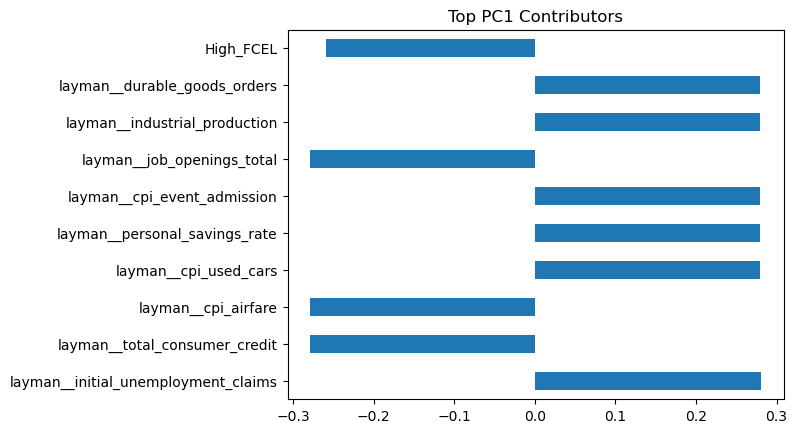

In [79]:
loadings["PC1"].sort_values(key=abs, ascending=False).head(10).plot(kind="barh", title="Top PC1 Contributors")

In [124]:
# 🧠 The Master Cell: Forecast + Adaptive Noise Engine

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load and prep dataset
df = pd.read_csv("selected_features_83_w_rare_events.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# Identify rare event flags and macro features
flag_cols = [col for col in df.columns if "flag" in col.lower()]
macro_features = df.drop(columns=["date"] + flag_cols).select_dtypes(include=[float, int]).columns.tolist()

# Forecast horizon
forecast_months = 120
future_dates = pd.date_range(start=df["date"].max() + pd.DateOffset(months=1), periods=forecast_months, freq="MS")

# Step 1: Forecast each macro feature (with fallback and convergence check)
forecasted_data = {}

for feature in macro_features:
    series = df[feature].copy()

    try:
        # Try Holt-Winters first
        model = ExponentialSmoothing(series, trend="add", seasonal=None)
        results = model.fit(optimized=True)
        
        # ✅ Explicit convergence check
        if not results.mle_retvals.get("converged", True):
            raise RuntimeError("Holt-Winters failed to converge")

        forecast = results.forecast(forecast_months)

    except:
        try:
            # Fallback to SARIMAX
            arima_model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False, enforce_invertibility=False)
            arima_results = arima_model.fit(disp=False)
            forecast = arima_results.forecast(steps=forecast_months)

        except:
            # Final fallback: repeat last value
            forecast = np.full(forecast_months, series.iloc[-1])

    forecasted_data[feature] = forecast

# Step 2: Build future DataFrame
df_future = pd.DataFrame(forecasted_data)
df_future["date"] = future_dates
for col in flag_cols:
    df_future[col] = np.nan

# Step 3: Join and extract 2025–2026 subset for z-spread calc
df_combined = pd.concat([df, df_future], ignore_index=True)
df_2025_2026 = df_combined[(df_combined["date"] >= "2025-01-01") & (df_combined["date"] <= "2026-12-31")]

# Step 4: Compute trend volatility (z_score_spread)
trends = []
numeric_cols = [col for col in df_2025_2026.select_dtypes(include=[float, int]).columns if "flag" not in col.lower()]
for col in numeric_cols:
    first_val = df_2025_2026[col].iloc[0]
    last_val = df_2025_2026[col].iloc[-1]
    mean_change = last_val - first_val
    pct_change = ((last_val - first_val) / first_val) * 100 if first_val != 0 else np.nan
    std_dev = df_2025_2026[col].std()
    z_spread = abs(mean_change / std_dev) if std_dev != 0 else np.nan
    trends.append((col, mean_change, pct_change, z_spread))

trend_df = pd.DataFrame(trends, columns=["feature", "mean_change", "percent_change", "z_score_spread"])
z_dict = trend_df.set_index("feature")["z_score_spread"].to_dict()

# Step 5: Add adaptive noise to forecasted features
for feature in forecasted_data:
    historical_std = np.std(df[feature])
    z_boost = z_dict.get(feature, 1.0)
    noise_scale = 0.01 * min(z_boost, 5)  # Limit wild scaling
    noise = np.random.normal(loc=0, scale=historical_std * noise_scale, size=forecast_months)
    forecasted_data[feature] += noise

# Step 6: Rebuild df_future with noisy data
df_future_noisy = pd.DataFrame(forecasted_data)
df_future_noisy["date"] = future_dates
for col in flag_cols:
    df_future_noisy[col] = np.nan

# Step 7: Final combined export
df_combined_noisy = pd.concat([df, df_future_noisy], ignore_index=True)
df_combined_noisy.to_csv("extrapolated_macro_features_with_zboosted_noise.csv", index=False)
print("✅ Saved: extrapolated_macro_features_with_zboosted_noise.csv")

# Optional: Visualize top movers
print("📈 Top Moving Features by z_score_spread:")
print(trend_df.sort_values(by="z_score_spread", ascending=False).head(10))

/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sophiaboettcher/anaconda3/li

✅ Saved: extrapolated_macro_features_with_zboosted_noise.csv
📈 Top Moving Features by z_score_spread:
                                      feature   mean_change  percent_change  \
21                layman__cpi_event_admission  5.360983e-01    7.080084e-02   
14                                  High_FCEL -4.321943e+01   -4.274919e+02   
62                         federal_funds_rate  8.375522e-13    1.571393e-11   
78                layman__rental_vacancy_rate  1.348077e-11    1.953735e-10   
29                          layman__oil_price  4.789689e-08    6.611940e-08   
20                    linchpin__import_prices -1.556539e-05   -1.612326e-06   
70  Unemployment_lag30_lag90_lag180_rolling90  7.980049e-08    2.131803e-06   
57                        linchpin__vix_index  1.369171e-06    7.891476e-06   
47                  Consumer Sentiment_lag180 -2.019063e-02   -2.615367e-02   
39                             interest rates  2.486525e-02    3.406198e-02   

    z_score_spread  
21     

In [126]:
df = pd.read_csv("extrapolated_macro_features_with_zboosted_noise.csv")
df["date"] = pd.to_datetime(df["date"])

In [128]:
trend_df = trend_df.sort_values(by="z_score_spread", ascending=False)
top_features = trend_df.head(5)["feature"].tolist()  # Or 10 if you want more

/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_83878/3696563168.py:16: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


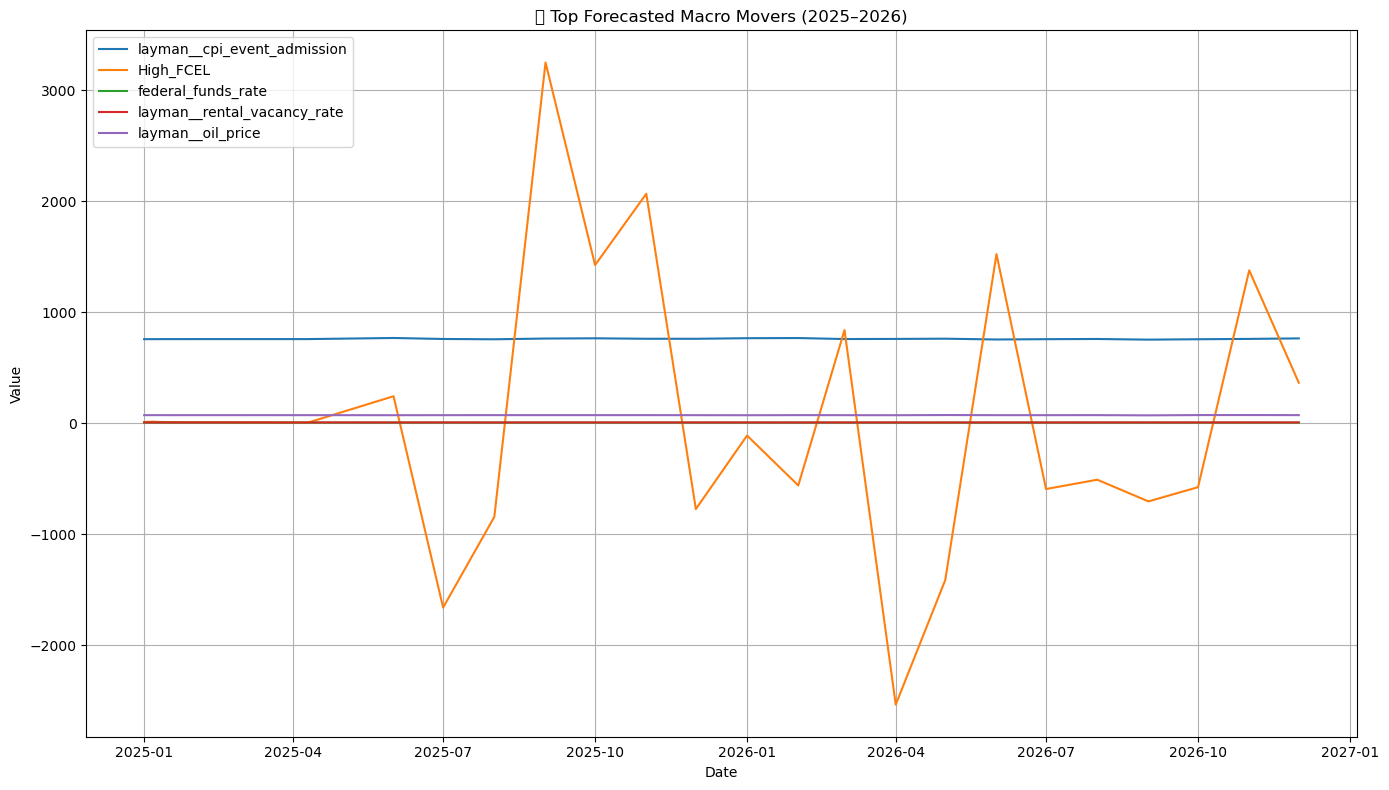

In [130]:
import matplotlib.pyplot as plt

# Filter data
df_2025_2026 = df[(df["date"] >= "2025-01-01") & (df["date"] <= "2026-12-31")]

# Plot top moving features
plt.figure(figsize=(14, 8))
for feature in top_features:
    plt.plot(df_2025_2026["date"], df_2025_2026[feature], label=feature)

plt.title("📈 Top Forecasted Macro Movers (2025–2026)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_83878/2516919104.py:14: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


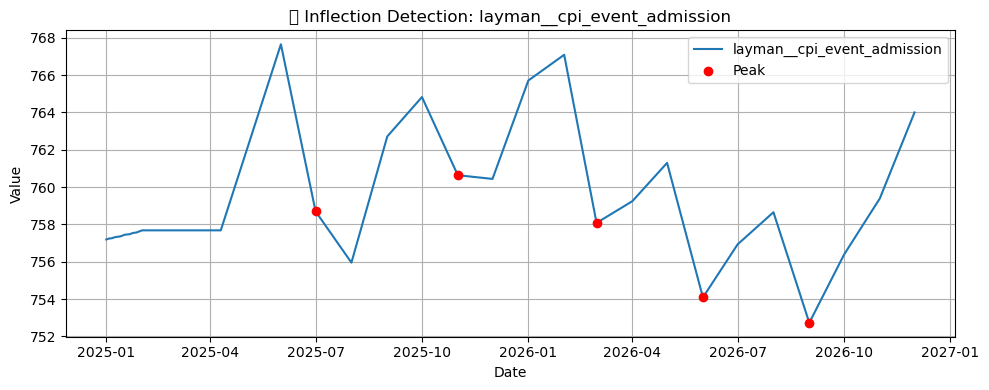

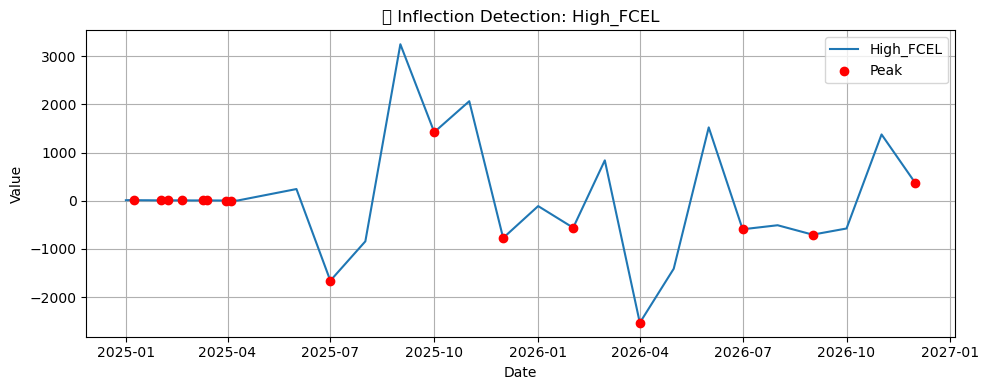

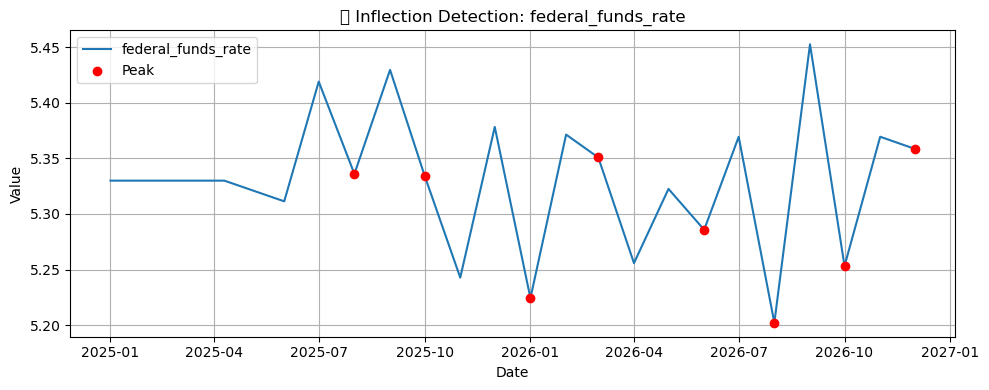

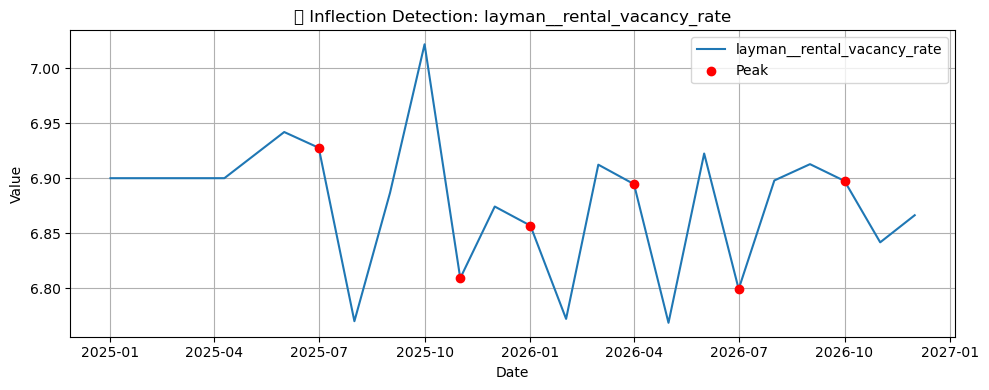

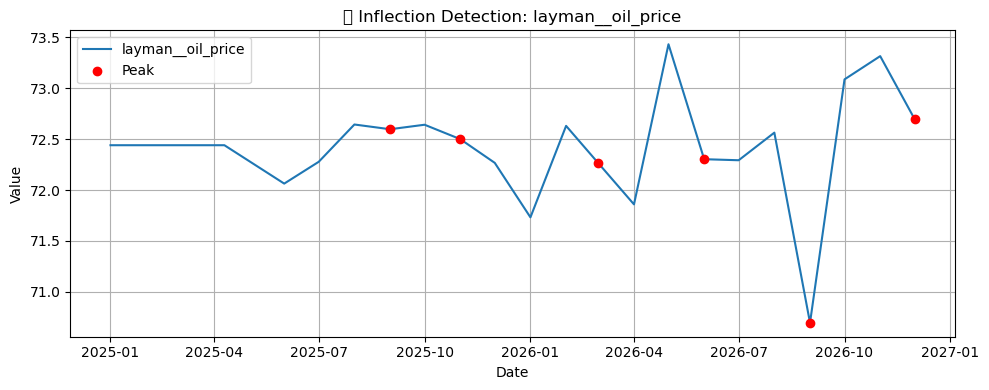

In [132]:
for feature in top_features:
    series = df_2025_2026[feature]
    delta = series.diff()
    turning_points = delta[(delta.shift(1) > 0) & (delta < 0)].index  # Peaks

    plt.figure(figsize=(10, 4))
    plt.plot(df_2025_2026["date"], series, label=feature)
    plt.scatter(df_2025_2026.loc[turning_points, "date"], series.loc[turning_points], color="red", label="Peak", zorder=5)
    plt.title(f"🔁 Inflection Detection: {feature}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [134]:
import matplotlib.pyplot as plt

def plot_forecasted_top_movers(df, trend_df, top_n=5, show_inflections=True, start_year="2025-01-01", end_year="2026-12-31"):
    """
    Plots top moving forecasted macro features and optionally highlights inflection points.
    
    Parameters:
    - df: full extrapolated dataframe (must include 'date')
    - trend_df: DataFrame with 'feature' and 'z_score_spread' from your top mover analysis
    - top_n: how many top movers to display
    - show_inflections: highlight local peaks (reversals) in each line
    - start_year, end_year: date range to show
    """
    df["date"] = pd.to_datetime(df["date"])
    df_range = df[(df["date"] >= start_year) & (df["date"] <= end_year)]
    
    top_features = trend_df.sort_values(by="z_score_spread", ascending=False).head(top_n)["feature"].tolist()
    
    for feature in top_features:
        plt.figure(figsize=(10, 5))
        plt.plot(df_range["date"], df_range[feature], label=feature, linewidth=2)
        
        if show_inflections:
            delta = df_range[feature].diff()
            turning_pts = delta[(delta.shift(1) > 0) & (delta < 0)].index  # Peaks
            if not turning_pts.empty:
                plt.scatter(df_range.loc[turning_pts, "date"], df_range.loc[turning_pts, feature],
                            color="red", label="Inflection Point", zorder=5)

        plt.title(f"📈 {feature} (Forecasted, {start_year[:4]}–{end_year[:4]})")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [138]:
def plot_forecasted_top_movers_concatenated(df, trend_df, top_n=5, show_inflections=True, start_year="2025-01-01", end_year="2026-12-31"):
    """
    Concatenated plot of top forecasted macro feature movers with optional inflection detection.
    """
    import matplotlib.pyplot as plt

    df["date"] = pd.to_datetime(df["date"])
    df_range = df[(df["date"] >= start_year) & (df["date"] <= end_year)]
    
    top_features = trend_df.sort_values(by="z_score_spread", ascending=False).head(top_n)["feature"].tolist()

    # Setup plot grid
    fig, axs = plt.subplots(nrows=top_n, ncols=1, figsize=(12, 2.5 * top_n), sharex=True)
    if top_n == 1:
        axs = [axs]  # handle single-plot case

    for i, feature in enumerate(top_features):
        ax = axs[i]
        ax.plot(df_range["date"], df_range[feature], label=feature, color="tab:blue", linewidth=2)
        
        if show_inflections:
            delta = df_range[feature].diff()
            turning_pts = delta[(delta.shift(1) > 0) & (delta < 0)].index  # Local peaks
            if not turning_pts.empty:
                ax.scatter(df_range.loc[turning_pts, "date"], df_range.loc[turning_pts, feature],
                           color="red", label="Inflection", zorder=5)
        
        ax.set_title(f"{feature}")
        ax.grid(True)
        ax.legend(loc="upper right")

    plt.suptitle("🌀 Forecasted Macro Feature Movers (2025–2026)", fontsize=16)
    plt.xlabel("Date")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # space for suptitle
    plt.show()

/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_83878/2204962967.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


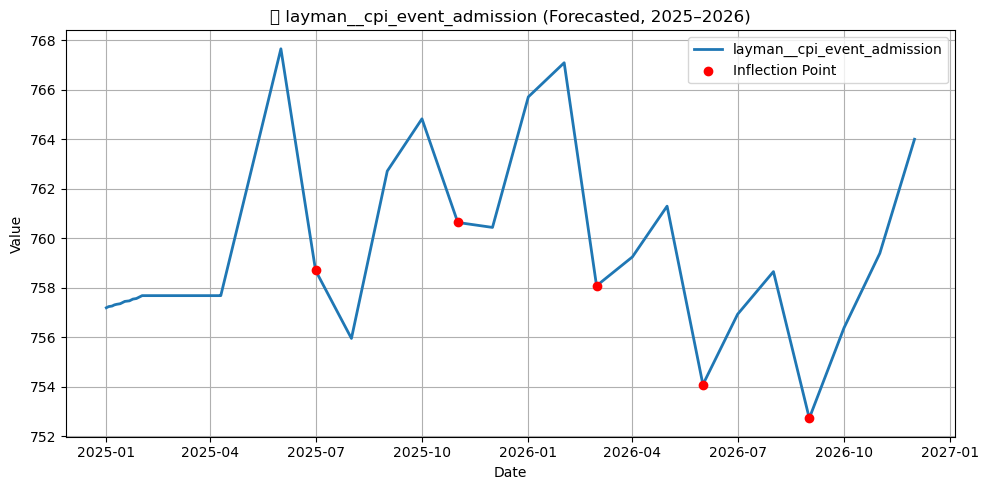

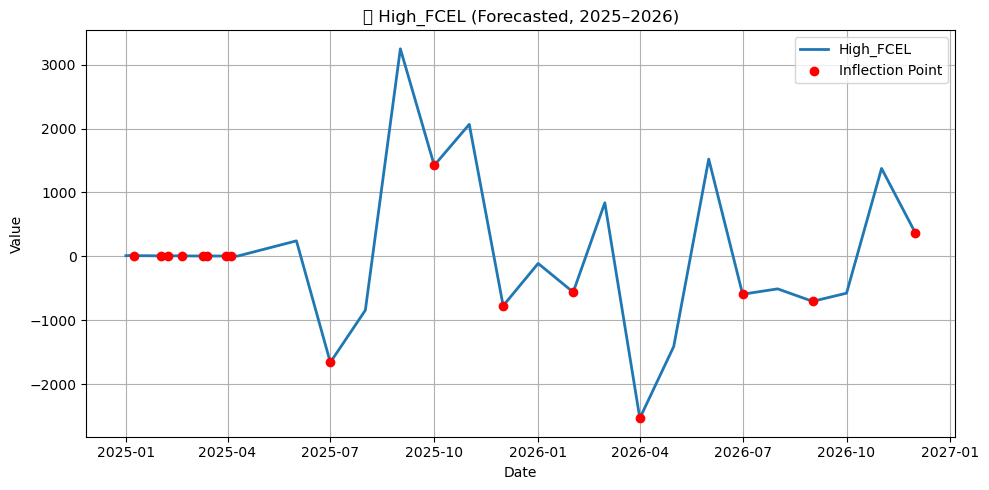

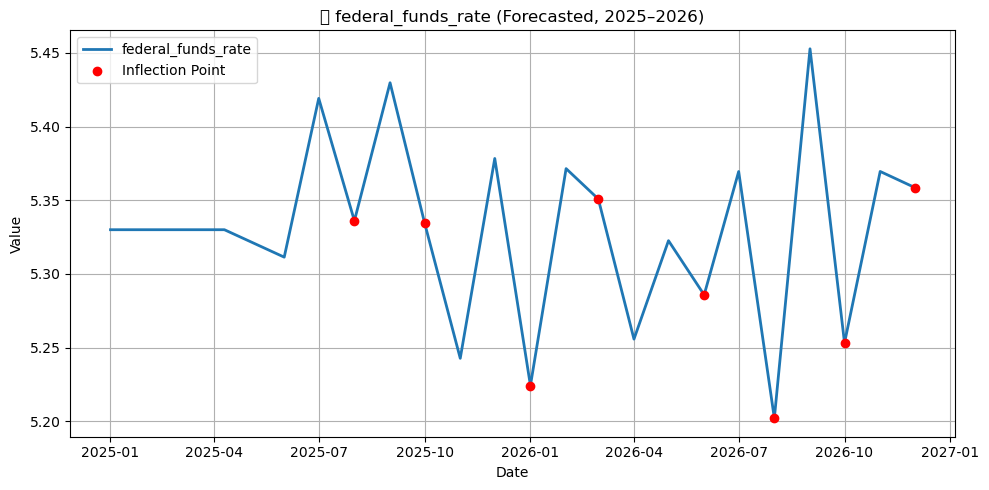

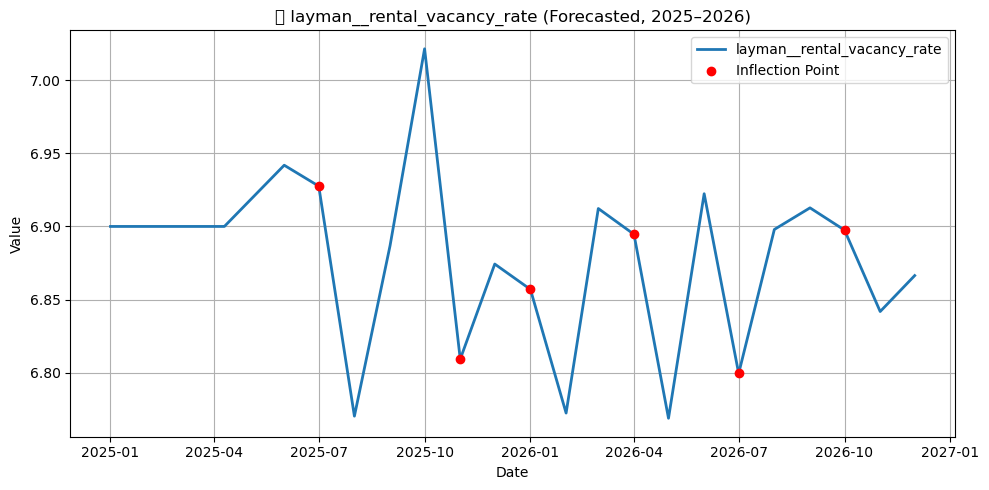

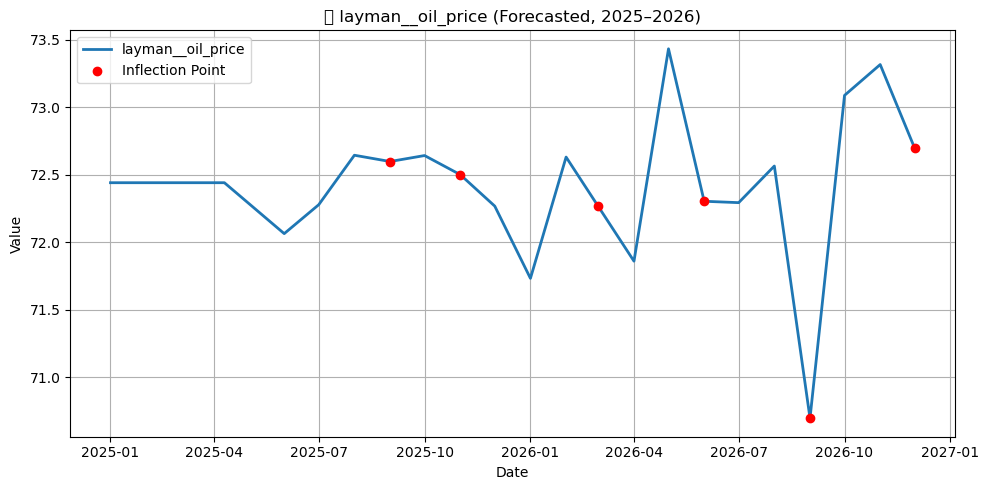

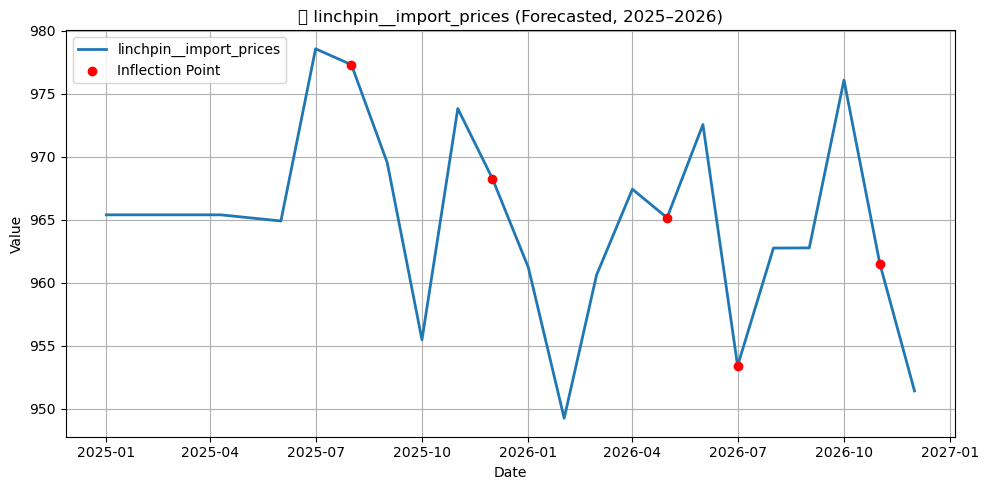

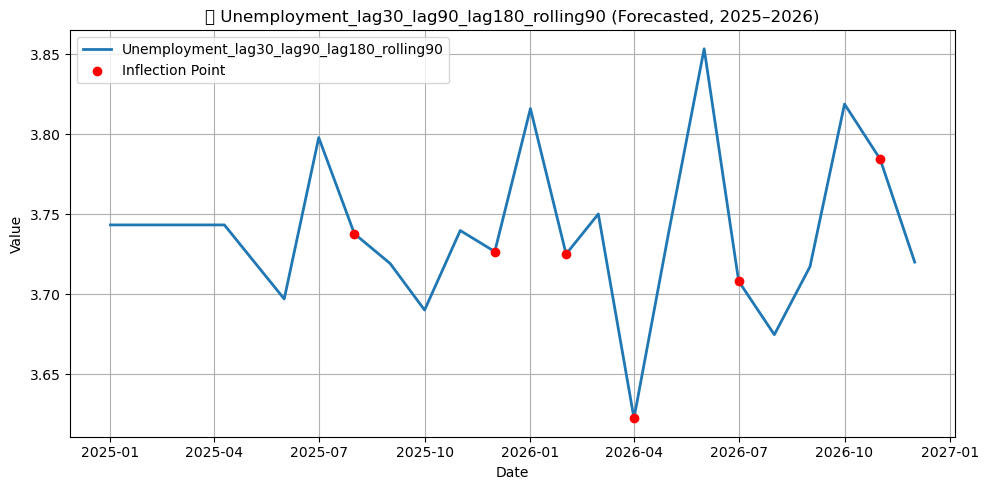

In [136]:
# First, make sure you have:
# df = pd.read_csv("extrapolated_macro_features_with_zboosted_noise.csv")
# trend_df = your z_score_spread DataFrame

plot_forecasted_top_movers(df, trend_df, top_n=7, show_inflections=True)

/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_83878/1413922192.py:34: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # space for suptitle
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


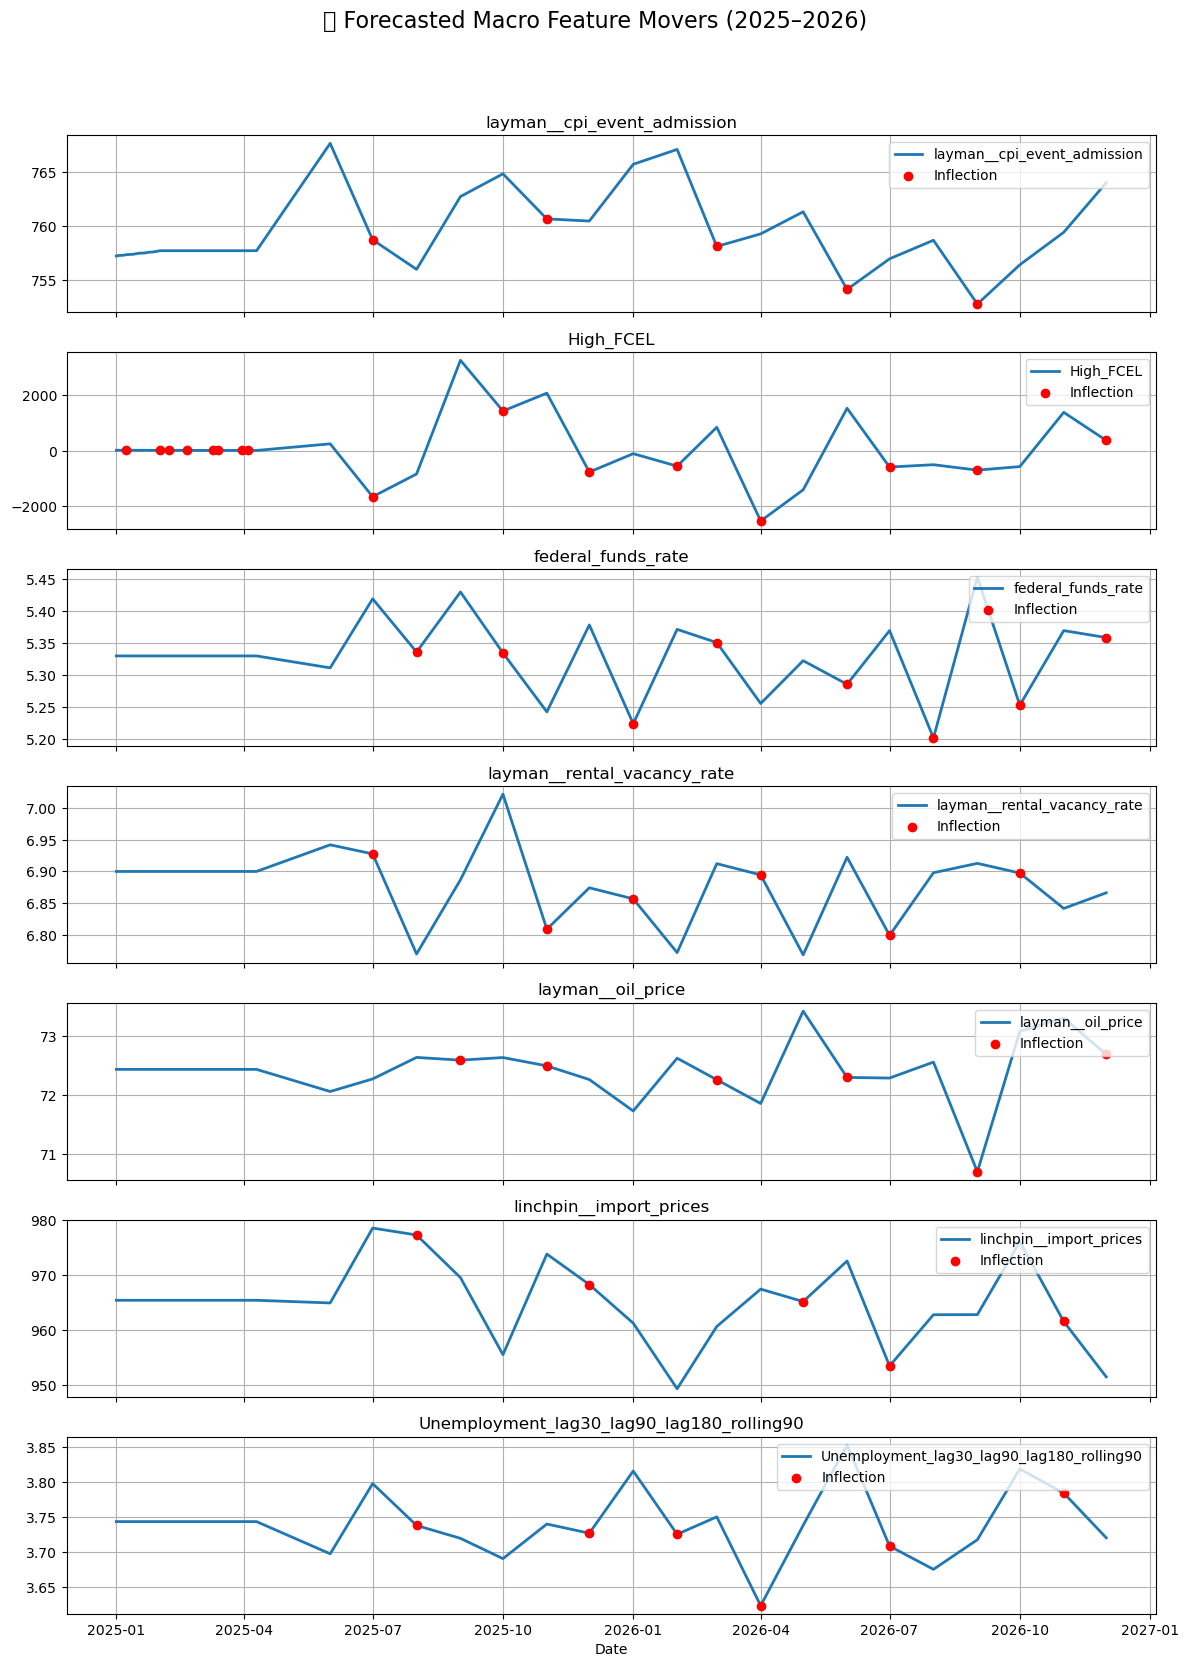

In [140]:
plot_forecasted_top_movers_concatenated(df, trend_df, top_n=7, show_inflections=True)

/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_83878/1945563732.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_filled = X.fillna(method='ffill').fillna(method='bfill')
/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_83878/1945563732.py:41: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  plt.tight_layout()
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


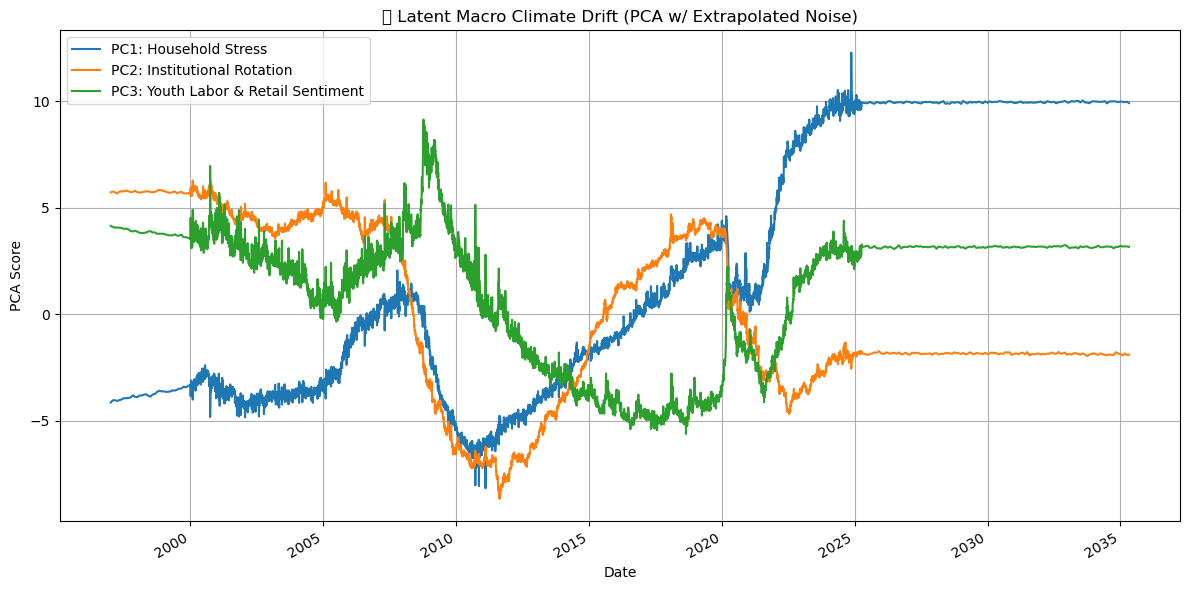

In [142]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Step 1: Clean numeric macro features (exclude flags)
numeric_cols = [col for col in df.select_dtypes(include=[float, int]).columns if 'flag' not in col.lower()]
X = df[numeric_cols]

# ✅ Step 2: Fill gaps to preserve full timeline
X_filled = X.fillna(method='ffill').fillna(method='bfill')

# ✅ Step 3: Normalize features
X_scaled = StandardScaler().fit_transform(X_filled)

# ✅ Step 4: Apply PCA
pca = PCA(n_components=3)
latent = pca.fit_transform(X_scaled)

# ✅ Step 5: Create readable PCA DataFrame
latent_df = pd.DataFrame(
    latent,
    columns=[
        "PC1: Household Stress",
        "PC2: Institutional Rotation",
        "PC3: Youth Labor & Retail Sentiment"
    ]
)
latent_df["date"] = df["date"].values

# ✅ Step 6: Plot the climate drift
latent_df.set_index("date")[
    ["PC1: Household Stress", "PC2: Institutional Rotation", "PC3: Youth Labor & Retail Sentiment"]
].plot(
    title="🌀 Latent Macro Climate Drift (PCA w/ Extrapolated Noise)",
    figsize=(12, 6)
)
plt.ylabel("PCA Score")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

In [144]:
latent_df["PC1_delta"] = latent_df["PC1: Household Stress"].diff()
latent_df["PC1_alert"] = (latent_df["PC1_delta"].abs() > 2 * latent_df["PC1_delta"].std())

🔍 PCA Decomposition: Latent Axes of Economic Weather

You’ve cracked open the PCA black box. Below is a breakdown of what each principal component appears to represent, based on its top contributing features.

⸻

🔹 PC1 — “Layman Confidence & Credit Pressure”

🧭 Interpretation Commentary
This component captures real-world consumer stress signals: how people feel about jobs, prices, and their wallets. It’s Main Street’s heartbeat.

📊 Top Contributing Features:
	•	⬆️ layman__initial_unemployment_claims → job losses rising
	•	⬇️ layman__total_consumer_credit → less borrowing
	•	⬇️ layman__cpi_airfare, used_cars, event_admission → deflation in travel & discretionary goods
	•	⬆️ layman__personal_savings_rate → precautionary saving behavior
	•	⬇️ layman__job_openings_total → labor market cooling

🧠 What this means:
PC1 is a latent axis of economic slowdown and consumer risk aversion — people are scared, spending less, and bracing for instability.

📛 Suggested Name:
	•	Main Street Contraction Axis
	•	Household Stress & Sentiment Composite

💡 Use this axis to flag household-driven recessions, stagflation concerns, or consumption slowdowns.

⸻

🔹 PC2 — “Big Tech Liquidity Fluctuation”

🧭 Interpretation Commentary
This one’s not about households — it’s about institutional behavior in public markets, especially large-cap tech.

📊 Top Contributing Features:
	•	⬆️ Volume_AAPL, AMZN, CSCO, ADBE, AMD → rising trading volumes
	•	⬇️ High_CSCO, High_AMD, High_ERIC → prices are failing to keep up

🧠 What this means:
PC2 appears to capture high-volume, low-price conditions — a potential distribution phase where smart money exits tech positions quietly.

📛 Suggested Name:
	•	Tech Liquidity Whiplash Vector
	•	Institutional Rotation Pulse

💡 Use this axis to monitor rotational stress, smart money exits, or shifts in risk-on/risk-off regimes.

⸻

🔹 PC3 — “Youth Employment & Blue-Collar Signal”

🧭 Interpretation Commentary
This dimension blends labor fragility (especially among youth) with cyclical market optimism, reflected through stocks like Ford and AMD.

📊 Top Contributing Features:
	•	⬆️ High_FORD → retail stock interest rising
	•	⬆️ layman__youth_unemployment_rate, part_time_econ_reasons → fragile labor market
	•	⬆️/⬇️ mixed movement in Volume_AMD, Volume_ERIC, High_AMD → speculative positioning

🧠 What this means:
PC3 seems to express the precarity of early-stage recovery — optimism on the surface, but structural fragility underneath.

📛 Suggested Name:
	•	Precarious Recovery Index
	•	Youth Fragility + Retail Risk Axis

💡 Use this axis to track job market fragility, policy targeting youth employment, or retail investor sentiment.

⸻

🌎 Summary: What These Components Reveal

These three PCs encode distinct economic “weather fronts”:

Component	Theme
PC1	Consumer sentiment, credit contraction, inflation relief
PC2	Market liquidity rotation, particularly in big tech
PC3	Youth/gig economy fragility blended with retail investor energy

In [ ]:
# 🌪️ PC1 — “Main Street Contraction Axis”
# 	•	🔺 Rising unemployment claims
# 	•	🔻 Falling consumer credit, job openings
# 	•	🧊 Deflationary pressures in airfare, used cars, entertainment
# 	•	🔺 Higher savings rate

# 🧠 This looks like early-stage household stress.
# 	•	Not panic yet, but defensive behavior: saving more, spending less
# 	•	Could precede a consumption slowdown or stagflation if it deepens

# 📉 Risk Level: Moderate → High
# 🧭 Interpretation: “Consumer winter is coming”

In [51]:
# 💸 PC2 — “Tech Liquidity Whiplash Vector”
# 	•	🔺 High trading volumes
# 	•	🔻 Price highs dropping

# 🧠 This is classic stealth repositioning.
# 	•	Institutional investors may be quietly exiting risk
# 	•	Volume up, prices flat/down = possible distribution phase

# 📉 Risk Level: Medium
# 🧭 Interpretation: “Smart money is moving before the lights go out”

In [53]:
# 🧑‍🎓 PC3 — “Precarious Recovery Index”
# 	•	🔺 Youth unemployment
# 	•	🔺 Part-time economy growing
# 	•	🔺 Ford and mid-tier tech showing life

# 🧠 This is a fragile labor market with speculative hope.
# 	•	“Recovery” narrative in headlines, but the underlying job market for younger workers is still cracked
# 	•	Could reverse hard with a shock

# 📉 Risk Level: Low → Watchlist
# 🧭 Interpretation: “It’s a paper-thin rebound.”

In [55]:
# # 	# •	Widening cracks in Main Street
# # 	# •	Repositioning in financial markets
# # 	# •	A fragile labor market disguised as a soft landing

# # If a triggering event occurs — geopolitical shock, Fed misstep, sudden spike in oil — this could evolve into a rare event scenario.

# Consumer & credit fragility: High
# Tech volume --> repositioning: Medium
# Youth labor tension: Low-moderate

🔍 Understanding the Challenge of Rare Event Prediction

Context

We are trying to detect and forecast rare events, such as recessions, using macroeconomic feature sets. We start with:
	•	An interpretable dataset of 83+ macro indicators (selected_features_83_w_rare_events.csv)
	•	A working reference format from market_shock_easy_s1.csv — which uses PCA-transformed, scalarized, anonymized data (feature_0 to feature_14) with a binary rare_event flag

Our goal: convert our interpretable macro dataset into a latent-space rare event detection system that can forecast, explain, and flag risk — even under conditions of extreme rarity.

⸻

🧠 What We’re Proposing (And Why It Works)

This is not just a classifier. It’s a full rare-event reasoning engine.

1. Extrapolate Data First (Without Labels)
	•	Extrapolate macroeconomic feature values, not outcomes.
	•	Use time-series models like ARIMA or exponential smoothing for each feature.
	•	Do not try to extrapolate the recession_flag, because that’s the thing we’re trying to predict.
	•	The forecasted rows will naturally have no label — this is realistic. We’re blind to the future.

📌 This builds the “what if” future scenario that our model will operate on.

⸻

2. PCA Transformation for Latent Modeling
	•	Apply PCA to the historical data (standardized).
	•	Keep the top 15 components, mirroring the market_shock_easy_s1.csv format.
	•	Then transform both historical and extrapolated datasets into the same latent space.

📌 Now, we’ve created a uniform, scalarized feature space for both past and future samples.

⸻

3. Train on Historical Latent Data to Predict Rare Events
	•	Use only the historical PCA-transformed data to train a model on nber_recession_flag.
	•	The model learns the latent patterns associated with historical rare events.

📌 This makes the model robust and generalizable — it learns “how a recession feels” in latent space.

⸻

4. Project Future Data + Predict
	•	Apply the trained model to the future PCA-transformed data.
	•	Since we have no future recession_flag, the model simply outputs a probability of rare event.
	•	This gives us soft signals about where risk is emerging — even without knowing for sure.

📌 You don’t predict labels you don’t have. You infer likely zones of instability.

⸻

5. Similarity Matching as a Second Signal
	•	Measure cosine similarity between each extrapolated row and known rare event rows in PCA space.
	•	If a future point is highly similar to a past rare event window, flag it.
	•	This works even if the classifier is uncertain — it’s memory-based analogy detection.

📌 We’re saying: “This future looks like a previous 2008 or 2020 moment.”

⸻

6. Causal Diagnostics (Why Did It Fire?)
	•	When a prediction fires (or similarity is high), go back to the PCA component loadings.
	•	Trace back which original macro indicators drove the risk signal in that component.
	•	Example:
“Prediction spike was driven by volatility, high youth unemployment, and falling housing starts.”

📌 This gives interpretability and causal storylines to otherwise opaque predictions.

⸻

🧨 Why the Traditional Benchmark Fails
	1.	It’s Trained to Be Conservative
	•	It learns “always predict no recession” and still scores high accuracy.
	2.	Rare Events Are Too Few
	•	The signal is too sparse, especially in a non-PCA space full of noise.
	3.	No Extrapolation
	•	It can’t “see ahead.” It’s always just mimicking the past.
	4.	No Analogy Memory
	•	It doesn’t know how to say, “this looks like 2008.”

⸻

❗ Important Clarification: Future rare_event Labels Are Blank on Purpose

Yes — when extrapolating, we do not create fake rare_event labels. Why?
	•	That would be cheating and introducing false positives.
	•	Instead, we:
	•	Predict probabilities (P(rare_event))
	•	Compare latent patterns via similarity
	•	Leave labels blank and allow flags to emerge organically based on pattern recognition

This mimics real decision-making: we don’t know the future. We forecast risk, track similarity, and flag anomalies.

⸻